# Comparing the Virtual Product output with notebook output

Need to test if virtual products is behaving as expected before attempting to scale the analysis using datacube stats.
To generate the virtual product, run `virtual_product_test.py`.


In [2]:
from datacube import Datacube
import numpy as np
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import sys

sys.path.append('../../Scripts')
from dea_datahandling import load_ard

In [2]:
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = Client(n_workers=4, threads_per_worker=1, memory_limit='7GB')
client


Client Scheduler: tcp://127.0.0.1:32894 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 28.00 GB


## Load data matching extents of VP 

In [3]:
lat, lon = -33.2, 149.1
buffer = 0.05
time = ('1987', '2010')


In [4]:
dc = Datacube(env='c3-samples')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir', 'fmask'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "average"}}    

In [5]:
ds = load_ard(dc=dc, dask_chunks={'x':100, 'y':100}, lazy_load=True,
            products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3'], ls7_slc_off=False,
            **query)
print(ds)

Loading ga_ls5t_ard_3 data
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 787 observations as a dask array
<xarray.Dataset>
Dimensions:    (time: 787, x: 356, y: 411)
Coordinates:
  * x          (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
  * y          (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * time       (time) datetime64[ns] 1987-05-29T23:14:05.701791 ... 2010-12-29T23:45:58.889071
Data variables:
    nbart_red  (time, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_nir  (time, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577


## Calculate climatologies

In [6]:
quarter= {'JFM': [1,2,3],
                       'FMA': [2,3,4],
                       'MAM': [3,4,5],
                       'AMJ': [4,5,6],
                       'MJJ': [5,6,7],
                       'JJA': [6,7,8],
                       'JAS': [7,8,9],
                       'ASO': [8,9,10],
                       'SON': [9,10,11],
                       'OND': [10,11,12],
                       'NDJ': [11,12,1],
                       'DJF': [12,1,2],
                      }

def ndvi_clim_mean(data):
#     print(data)
    def attrs_reassign(da, dtype=np.float32):
        da_attr = data.attrs
        da = da.assign_attrs(**da_attr)
        return da
    
    ndvi = xr.Dataset(data_vars={'ndvi': (data.nbart_nir - data.nbart_red) / (data.nbart_nir + data.nbart_red)},
                          coords=data.coords,
                          attrs=dict(crs=data.crs))
#     print(ndvi)
    ndvi_var = []
    for q in quarter:
        ix=ndvi['time.month'].isin(quarter[q])
        ndvi_clim_mean=ndvi.where(ix,drop = True).mean(dim='time')   
        ndvi_clim_mean=ndvi_clim_mean.to_array(name='ndvi_clim_mean_'+q).drop('variable').squeeze()
        ndvi_var.append(ndvi_clim_mean)

    q_clim_mean = xr.merge(ndvi_var)   

    #assign back attributes
    q_clim_mean.attrs = data.attrs 
    q_clim_mean = q_clim_mean.apply(attrs_reassign, keep_attrs=True)  

    return q_clim_mean

In [7]:
clim = ndvi_clim_mean(ds)
print(clim)

<xarray.Dataset>
Dimensions:             (x: 356, y: 411)
Coordinates:
  * x                   (x) float64 1.573e+06 1.574e+06 ... 1.584e+06 1.584e+06
  * y                   (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06
Data variables:
    ndvi_clim_mean_JFM  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_FMA  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_MAM  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_AMJ  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_MJJ  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_JJA  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_JAS  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_ASO  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ndvi_clim_mean_SON  (y, x) float32 dask.arra

In [8]:
clim = clim.compute()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50008 remote=tcp://127.0.0.1:32894>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50010 remote=tcp://127.0.0.1:32894>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50012 remote=tcp://127.0.0.1:32894>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50014 remote=tcp://127.0.0.1:32894>


## Open VP dataset

In [4]:
vp_clim = xr.open_dataset('mergeworkflows_test_1987_2010.nc').squeeze()
print(vp_clim)

<xarray.Dataset>
Dimensions:             (x: 356, y: 411)
Coordinates:
  * y                   (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06
  * x                   (x) float64 1.573e+06 1.574e+06 ... 1.584e+06 1.584e+06
Data variables:
    crs                 int32 ...
    ndvi_clim_mean_JFM  (y, x) float64 ...
    ndvi_clim_mean_FMA  (y, x) float64 ...
    ndvi_clim_mean_MAM  (y, x) float64 ...
    ndvi_clim_mean_AMJ  (y, x) float64 ...
    ndvi_clim_mean_MJJ  (y, x) float64 ...
    ndvi_clim_mean_JJA  (y, x) float64 ...
    ndvi_clim_mean_JAS  (y, x) float64 ...
    ndvi_clim_mean_ASO  (y, x) float64 ...
    ndvi_clim_mean_SON  (y, x) float64 ...
    ndvi_clim_mean_OND  (y, x) float64 ...
    ndvi_clim_mean_NDJ  (y, x) float64 ...
    ndvi_clim_mean_DJF  (y, x) float64 ...
Attributes:
    date_created:           2020-01-22T21:42:09.232412
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+2...
    geospatial_bo

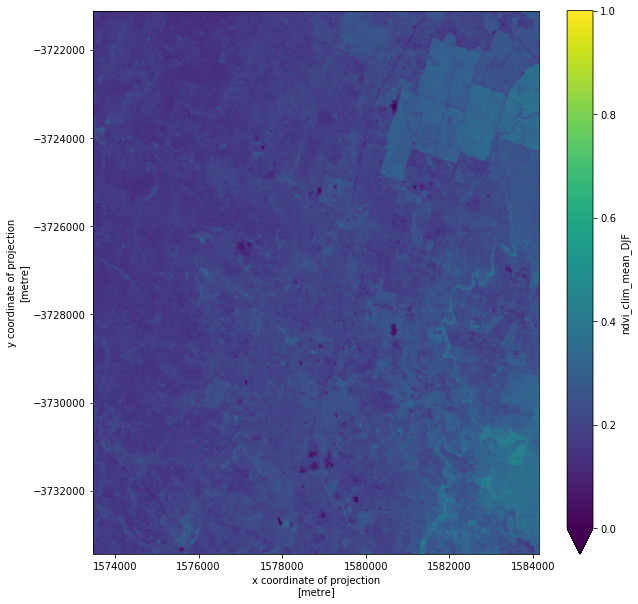

In [5]:
# clim.ndvi_clim_mean_DJF.plot(vmin=0, vmax=1.0, cmap='viridis')
vp_clim.ndvi_clim_mean_DJF.plot(vmin=0, vmax=1.0, cmap='viridis' ,figsize=(10,10))

## Calculate deltas

In [18]:
diff_DJF = clim.ndvi_clim_mean_DJF - vp_clim.ndvi_clim_mean_DJF
diff_MAM = clim.ndvi_clim_mean_MAM - vp_clim.ndvi_clim_mean_MAM
diff_JJA = clim.ndvi_clim_mean_JJA - vp_clim.ndvi_clim_mean_JJA
diff_SON = clim.ndvi_clim_mean_SON - vp_clim.ndvi_clim_mean_SON

### Plot differences, ideally every pixel will be zero

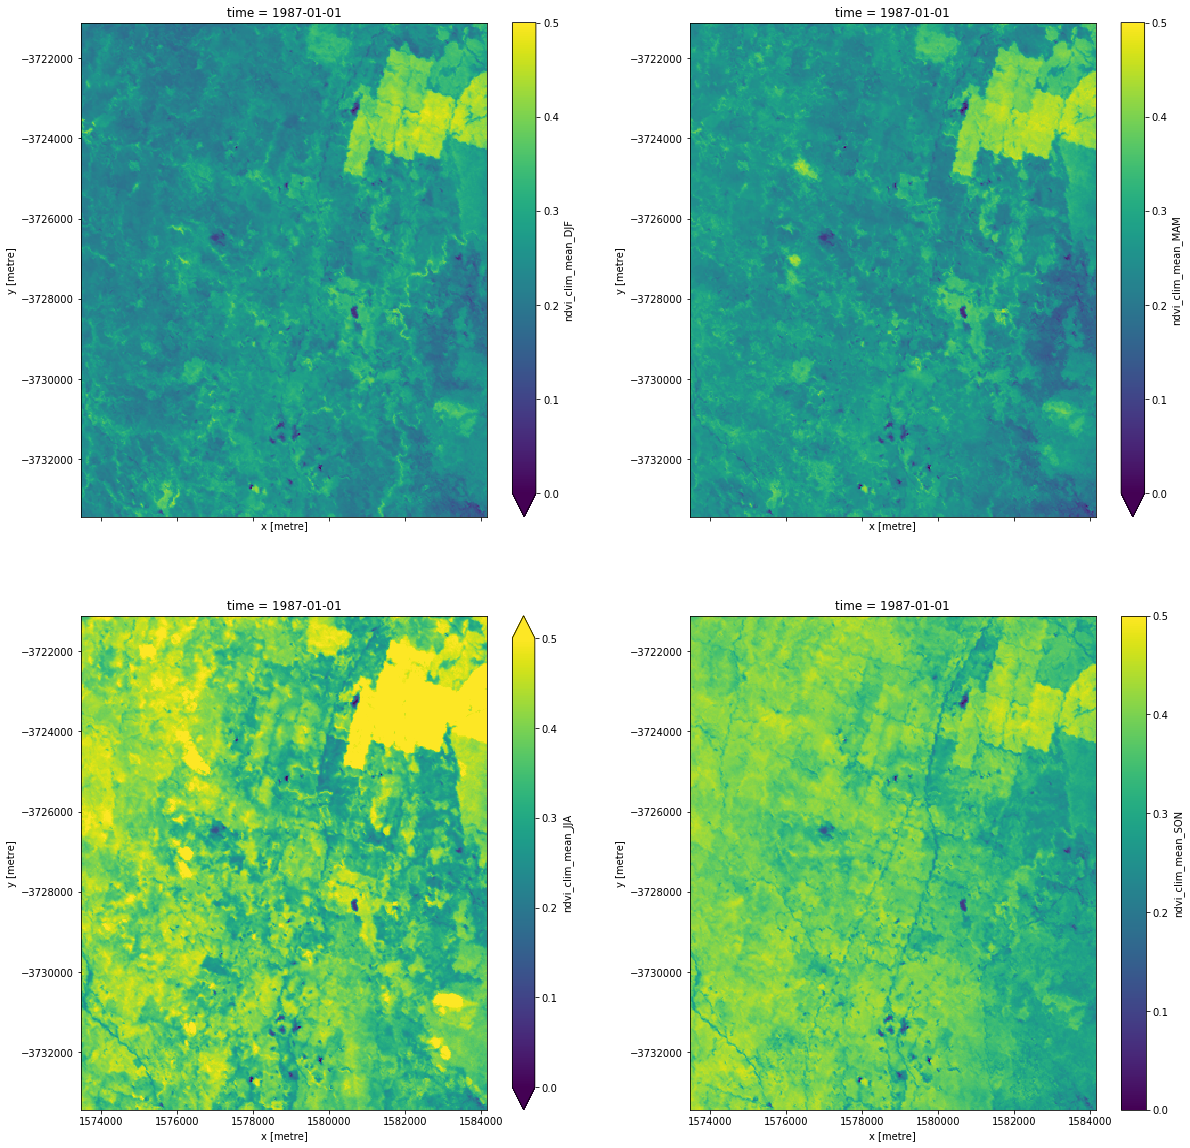

In [20]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots(nrows=2, ncols=2, sharex='all')
diff_DJF.plot(ax=ax[0,0], cmap='viridis', vmin=0, vmax=0.5)
diff_MAM.plot(ax=ax[0,1], cmap='viridis', vmin=0, vmax=0.5)
diff_JJA.plot(ax=ax[1,0], cmap='viridis', vmin=0, vmax=0.5)
diff_SON.plot(ax=ax[1,1], cmap='viridis', vmin=0, vmax=0.5)

In [ ]:
#Print statements from VP test

#Input data:
xarray.Dataset>
Dimensions:    (time: 787, x: 356, y: 411)
Coordinates:
  * time       (time) datetime64[ns] 1987-05-29T23:14:05.701791 ... 2010-12-30T23:43:03.718821
  * y          (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x          (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
Data variables:
    nbart_red  (time, y, x) int16 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nbart_nir  (time, y, x) int16 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

# NDVI data            
<xarray.Dataset>
Dimensions:  (time: 787, x: 356, y: 411)
Coordinates:
  * time     (time) datetime64[ns] 1987-05-29T23:14:05.701791 ... 2010-12-30T23:43:03.718821
  * y        (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x        (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
Data variables:
    ndvi     (time, y, x) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

#Output dataset
<xarray.Dataset>
Dimensions:             (x: 356, y: 411)
Coordinates:
  * y                   (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06
  * x                   (x) float64 1.573e+06 1.574e+06 ... 1.584e+06 1.584e+06
Data variables:
    ndvi_clim_mean_JFM  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_FMA  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_MAM  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_AMJ  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_MJJ  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_JJA  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_JAS  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_ASO  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_SON  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_OND  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_NDJ  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
    ndvi_clim_mean_DJF  (y, x) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>